In [30]:
import os
import librosa as liro
import librosa.display as lirod
import matplotlib
from matplotlib import pyplot as plt
import IPython.display as ipd
import torch 
import torch.nn as nn
import torchaudio
from scipy.fft import rfft, rfftfreq
import numpy as np

wd = os.getcwd()
os.chdir(os.path.join(wd, ".."))

from models.mel import AugmentMelSTFT
from datasets import audiodataset

os.chdir(wd)

example_data_path = os.path.join("..", "datasets", "example_data", "audio")
example_file = os.path.join(example_data_path, "dog_bark.wav")

import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(mel_specgram_db, waveform, sample_rate):
    num_frames = mel_specgram_db.shape[-1]
    duration = len(waveform[0]) / sample_rate
    num_mel_bins = mel_specgram_db.shape[1]

    plt.figure(figsize=(12, 4))  # wider, less tall
    plt.imshow(
        mel_specgram_db[0].numpy(),
        cmap='magma',
        origin='lower',
        aspect='auto',
        extent=[0, duration, 0, num_mel_bins]
    )
    plt.colorbar(label='dB')
    plt.xlabel('Time [s]')
    plt.ylabel('Mel Bin')
    plt.title('Log Mel Spectrogram')
    plt.tight_layout()
    plt.show()

# Today's Menu

- **Introduction to Pipeline**
    * Tips & Tricks for building an ML pipeline
    * Audio Preprocessing
    * Example Pipeline on GitHub
- **Your next task**
- **Questions**
- **Presentations**

# Are we complete?

* Team Task 1?
* Team Task 4?
* Team Task 6?
* Team AES: QVIM?

# Introduction to Pipeline

## Pipeline - Expectation


<center>
<img src="figs/expectation.jpg" alt="drawing" width="600"/>
</center>

## Pipeline - Reality

<center>
<img src="figs/reality.jpg" alt="drawing" width="600"/>
</center>

## Tips & Tricks for building an ML pipeline

## Best Practices for ML Pipelines

- **Document everything**  
  Your future self (and your teammates) should understand *what* you did, *why* you did it, and *how* it works.

- **Double-check your steps**  
  Small mistakes (e.g., data leakage, wrong labels, off-by-one errors) can silently propagate and waste hours later.

- **Log everything**  
  Track parameters, results, errors, and unexpected behaviors. Good logs = easy debugging.

- **Use version control**  
  Commit early, commit often. Track your code *and* configs to understand changes over time.

- **Automate where possible**  
  Make your pipeline reproducible. E.g., use scripts to run multiple commands. 

- **Keep it simple (at first)**  
  Start with a minimal working version, then iterate. Don’t over-engineer early.

## Documentation

- Maintain a continuously updated **work log**  
  Your colleagues (and future you) should be able to quickly understand what you've done and why.

- A good work log saves time when writing your **technical report**  
  You’ll thank yourself later when everything is already written down.

- Store your work log in **version control**  
  Or at least use a shared document if collaborating—keep everything accessible and trackable.

- **Collect questions** for the teaching team in your work log  
  This helps identify common issues and makes discussions more efficient.

- Add comments to your code, focusing on **why** things are done  
  Don't just write *what* the code does—explain the reasoning behind key decisions.

## Version Control

- Use **Git** — it's the standard tool for version control  
  Learn the basics well (commits, branches, merges, resolving conflicts).

- When collaborating, work on your own **branches**  
  This avoids conflicts and allows for parallel development.

- **Merge frequently**  
  Don’t let branches drift too far apart — regular merges help catch issues early.

- Keep the **main/master branch stable and runnable**  
  Treat it as your working baseline; don’t break it.

- Review new features as a **group before merging**  
  Ensure everyone is on the same page and avoid unexpected issues in shared code.

## Testing & Sanity Checks

Run small, regular tests to avoid wasting time debugging later:

- **Exploratory tests**  
  Try out unfamiliar libraries or functions in a Jupyter Notebook to quickly learn how they behave.

- **Sanity checks for your own code**  
  Test functions like data loading, augmentation, or feature extraction on a few samples. Print shapes, min/max, or visualize outputs.

- **Visual inspection**  
  Plot spectrograms, embeddings, or model outputs to ensure your pipeline behaves as expected.

- **Overfit a tiny batch**  
  A classic trick: your model should be able to overfit 1–2 training examples. If it can’t, something’s likely wrong.

- **Group review of key changes**  
  Before running full experiments, verify new code together — four eyes catch more bugs than two.

## Reproducibility: What Can Break It?

- **Code & Dependencies**
  - Changing library versions (e.g., PyTorch, NumPy) can change behavior
  - Solution: use virtual environments (e.g., `conda`, `venv`) and freeze dependencies (`requirements.txt` or `environment.yml`)

- **Training Pipeline**
  - Pseudo-random number generators (PRNGs): Python, NumPy, PyTorch, etc.
  - Parallelism (e.g., multi-GPU, DataLoader workers) can introduce variability
  - Non-deterministic GPU ops (e.g., certain cuDNN kernels, FP16 ops)

- **Data Preprocessing**
  - Augmentations, shuffling, random splits, and label generation must be deterministic
  - Even slight differences (e.g., rounding, file order) can change results

## Reproducibility: How to make deterministic?

```python

# Set all PRNGs
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Enforce deterministic ops (optional, slows things down)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pl.seed_everything(SEED, workers=True) # Let Lightning seed everything, including workers

loader = DataLoader(
    dataset,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED), # Reproducible DataLoader shuffling
    ...
)

log = {"seed": SEED, "git_commit": ..., "torch_version": torch.__version__, ...}
```

## Data Leakage

- **Always use the provided split for your task**  
- Ensure that **no information from the test set leaks** into training or validation. This includes label distribution, normalization stats, data augmentations, etc.
- **Normalization leakage** is a common pitfall: Don’t compute mean/std over the full dataset — only use training data stats.
- Best practice: Treat your test set as **untouchable** — only access it once, at the very end, for final evaluation.


<center>
<img src="figs/leakage.png" alt="drawing" width="600"/>
</center>

## Leakage across devices

* In DCASE Task 1, **recording devices** are a major source of domain shift. 
* Measuring **generalization performance to unseen devices** is crucial.
* Splitting data without considering the recording device causes leakage and may inflate your results. Use the **provided split**, which accounts for device separation.

<center>
<img src="figs/leakage_devices.png" alt="drawing" width="600"/>
</center>

## PyTorch Lightning: Minimal Interface

```python
class MyModel(pl.LightningModule):
    def __init__(self, n_classes=10):
        super().__init__()
        self.model = torch.nn.Linear(128, n_classes)  # example model
        self.validation_step_outputs = []

    def forward(self, x):
        return self.model(x)  # inference step

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        self.validation_step_outputs.append(...)
        return val_loss

    def on_validation_epoch_end(self):
        self.log("val/accuracy", ...)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

if __name__ == "__main__":
    model = MyModel(n_classes=10)
    train_loader, val_loader = ...  # define DataLoaders
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, train_loader, val_loader)
```

## Weights and Biases: Minimal Interface


```python
def main(config):
    wandb_logger = WandbLogger(
        project="my-project",
        name=config.experiment_name,
        config=vars(config)  # logs all argparse args as W&B config
    )
    
    trainer = pl.Trainer(
        max_epochs=config.n_epochs,
        logger=wandb_logger
    )
    ...

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--n_epochs", type=int, default=10)
    parser.add_argument("--experiment_name", type=str, default="minimal-wandb-run")
    args = parser.parse_args()

    try:
        commit_hash = subprocess.check_output(["git", "rev-parse", "HEAD"]).decode("ascii").strip()
    except Exception:
        commit_hash = "unknown"

    args.commit_hash = commit_hash  # include in logged config

    # save library versions for reproducibility
    args.versions = {
        "torch": torch.__version__,
        ...
    }

    main(args)
```

## Audio Preprocessing

### Disclaimer:

The following section is a **practical introduction** to audio preprocessing for deep learning. It is meant to help you:

- Understand common steps and hyperparameters used in audio pipelines
- Interpret preprocessing choices in research papers and codebases
- Build your **first Audio Deep Learning pipeline** with confidence

What this **is not**:

- ❌ A deep dive into the mathematical theory behind signal processing  
- ❌ A substitute for a full course on digital signal processing (DSP)

If you're curious to go deeper into the math, we highly recommend  
📘 [The Scientist and Engineer's Guide to Digital Signal Processing](https://www.dspguide.com/)

## Overview

Audio signals are almost always converted into a **audio-visual representation**, typically a **spectrogram**, before being used in deep learning models. 

A typical preprocessing pipeline (see [example pipeline on GitHub](https://github.com/fschmid56/malach24)) includes:

- **Pre-emphasis filter**: a simple FIR filter applied in the time domain to amplify high frequencies and flatten the spectrum
- **Short-Time Fourier Transform (STFT)**: converts the time-domain signal into a time–frequency representation
- **Power spectrogram**: compute the squared magnitude of the complex STFT (|STFT|²)
- **Mel filterbank**: project the linear frequency bins onto the mel scale to better match human auditory perception
- **Logarithmic compression** → **log mel spectrogram**: approximates human loudness perception by applying a log function

## Long story Short

Our starting point: ... a dog barking

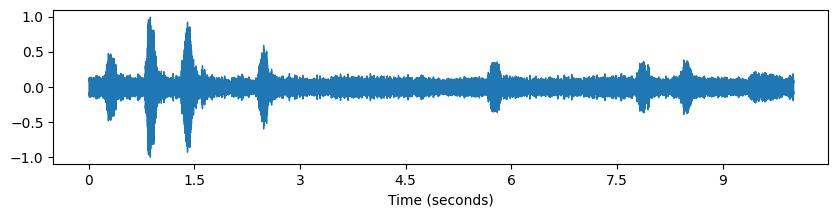

In [31]:
sr = 32000 
example_wav, _ = liro.load(example_file, sr=sr)
wav_plot(example_wav, sr)

## Long Story Short

In [32]:
from torchaudio import transforms

waveform, sample_rate = torchaudio.load(example_file)
print(waveform.shape)
waveform = waveform.mean(dim=0, keepdim=True)  # convert to mono
transform = transforms.MelSpectrogram(sample_rate, n_fft=800,
                                      n_mels=80)
mel_specgram = transform(waveform)

torch.Size([1, 320000])


## Long Story Short

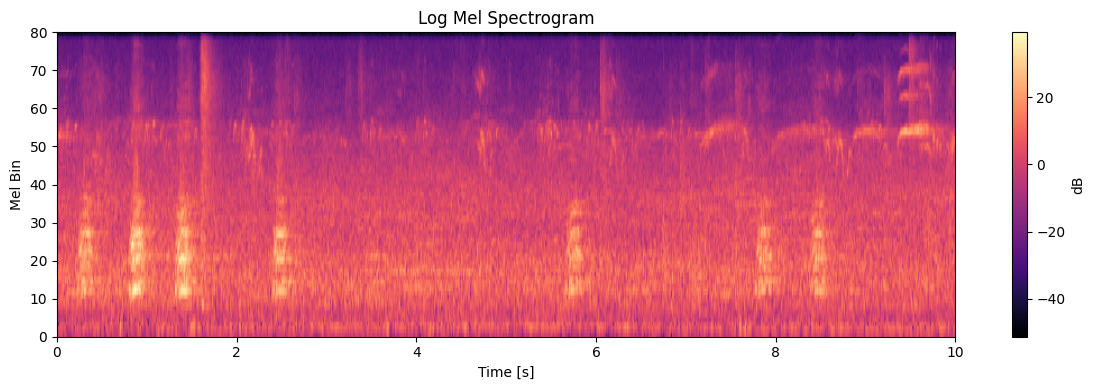

In [54]:
# Convert to dB scale for better visualization
mel_specgram_db = transforms.AmplitudeToDB()(mel_specgram)

plot_spectrogram(mel_specgram_db, waveform, sample_rate)

## Our Starting Point

* **Sound**: variation in air pressure at a point in space as a function of time
* The microphone turns the mechanical energy of a soundwave into an analog electrical signal
* To process it with a computer, we convert it into a **digital signal**, which involves:
  - **Sampling**: measuring the signal at regular time intervals (**sampling rate**, e.g., 44,100 times per second)
  - **Quantization**: rounding each sample to a fixed set of amplitude levels (**bit depth**, e.g., 16-bit resolution)



<center>
<img src="figs/digitized_signal.png" alt="drawing" width="300"/>
</center>

## The Sampling Theorem

- A continuous (analog) signal can be **properly sampled** if it contains **no frequency components above half the sampling rate**
  - This limit is called the **Nyquist frequency**
  - Example: for a sampling rate of 44,100 Hz → Nyquist frequency = 22,050 Hz

- If the signal meets this condition, it can be **reconstructed exactly** from its samples

- Frequencies **above the Nyquist limit** will be **aliased** — incorrectly folded into lower frequencies:
  → results in **distortion** and **irrecoverable information loss**

- To prevent aliasing: Apply an **analog low-pass filter** before digitizing the signal

## The Sampling Theorem

<center>
<img src="figs/sampling_theorem.png" alt="drawing" width="700"/>
</center>

## Digital Filters

- Digital filters are essential tools in audio processing  
  → used to enhance, suppress, or separate signal components

- Can operate in the **time** or **frequency domain**

- Typical applications:
  - Denoising / restoration
  - Source separation
  - Emphasizing certain frequencies (e.g., pre-emphasis)

- Defined by their **impulse response** or **frequency response**

- Two main types:
  - **FIR (Finite Impulse Response)** → implemented via convolution
  - **IIR (Infinite Impulse Response)** → uses recursion (feedback)

See the **pre-emphasis filter** in the example pipeline


## Discrete Fourier Transform (DFT)

- The DFT analyzes **discrete-time** signals in terms of their **frequency components**
- It assumes the signal is **finite, periodic**, and **repeats infinitely** in both directions
- The result is a set of **complex coefficients**, each representing a sinusoidal basis function:

$$
X[k] = \frac{1}{N} \sum_{n=0}^{N-1} x[n] \cdot e^{\frac{-2\pi i k n}{N}}
$$

- $X[k]$: complex amplitude of the $k$-th frequency bin  
- $N$: number of time samples  
- The exponent represents a **complex sinusoid** (a rotating vector)



## Discrete Fourier Transform (DFT)

Using Euler’s formula:

$$
e^{ix} = \cos(x) + i \sin(x)
$$

we can write:

$$
X[k] = \frac{1}{N} \sum_{n=0}^{N-1} x[n] \cdot \cos\left(\frac{-2\pi k n}{N}\right)
+ i \cdot x[n] \cdot \sin\left(\frac{-2\pi k n}{N}\right)
$$

- The **real part** corresponds to how much of a **cosine wave** (frequency $k$) is present in the signal  
- The **imaginary part** corresponds to how much of a **sine wave** (same frequency $k$) is present  

$\rightarrow$ The DFT tells us **how much of each sine and cosine wave at frequency $k$** is needed to reconstruct the signal.

## Discrete Fourier Transform

Basis functions for 16-point DFT.

<center>
<img src="figs/basis.png" alt="drawing" width="400"/>
</center>

## Discrete Fourier Transform

* The time-domain signal consists of $N$ samples: $x[0] \dots x[N-1]$
* The DFT translates this into $\frac{N}{2} + 1$ sine (imaginary) and cosine (real) amplitudes
* The DFT can be computed via:
  - **Matrix multiplication** with sine/cosine basis → $O(N^2)$
  - Or much faster using the **Fast Fourier Transform (FFT)** → $O(N \log N)$

<center>
<img src="figs/DFT.png" alt="drawing" width="500"/>
</center>

## Magnitude and Phase

- Each DFT coefficient $X[k]$ is a **complex number** with:
  - a **real part** (cosine component)
  - an **imaginary part** (sine component)

- These can be converted to **polar form**:
  - **Magnitude**:  
    $$ |X[k]| = \sqrt{(\mathrm{Re}\,X[k])^2 + (\mathrm{Im}\,X[k])^2} $$
  - **Phase** (angle):  
    $$ \phi[k] = \arctan2(\mathrm{Im}\,X[k], \mathrm{Re}\,X[k]) $$

- In many applications:
  - We use only the **magnitude spectrum**
  - The **phase** is often ignored — the human ear is mostly **insensitive to phase**, except in some edge cases (e.g., localization, transients)

- The **magnitude** of bin $X[k]$ reflects how much **energy** is present in its frequency band

<center>
<img src="figs/mag_phase.png" alt="drawing" width="400"/>
</center>


## Frequency Resolution

* An $N$-point FFT (typically with $N$ as a power of 2) produces $\frac{N}{2} + 1$ frequency bins for real-valued input
* These bins are **uniformly spaced** from $0$ to $\frac{S}{2}$ Hz, where $S$ is the **sampling rate**
* The **frequency spacing between bins** is: $\Delta f \approx \frac{S}{N}$
→ This is often called the **frequency resolution**

- To get more finely spaced bins in the frequency domain:
  - You can **increase $N$ by zero-padding** the signal (appending zeros)
  - This improves **visual resolution**, but not **true spectral resolution**

<center>
<img src="figs/zero_padding.png" alt="drawing" width="600"/>
</center>

## Spectral Leakage and Windowing

- The DFT assumes the signal is **periodic** over the analysis window  
  → It treats the time-domain signal as if it's **infinitely repeated**

<center>
<img src="figs/signal_repeated.png" alt="drawing" width="800"/>
</center>

- If a sinusoid does **not complete an integer number of cycles** within the window:
  - It gets **cut off at the edges**
  - This introduces **discontinuities** at the window boundaries

- These sharp edges cause **spectral leakage**:
  - Energy from a single frequency spreads into **many DFT bins**
  - This effect requires **many basis functions** to explain the edge artifacts

<center>
<img src="figs/spectral_leakage.png" alt="drawing" width="400"/>
</center>

## Spectral Leakage and Windowing

- To reduce discontinuities at the window edges, we **multiply the signal with a window function**
  → This **smoothly tapers** the signal to zero at the edges  
  → Prevents sharp "cuts" that cause spectral leakage

- With proper windowing, sine waves that **don’t perfectly align with DFT bins** produce **cleaner, more localized peaks**

- Common window functions:
  - **Hann**, **Hamming**, **Blackman**, **Gaussian**, etc.

- There’s a **trade-off**:
  - **Narrow peak** → better frequency resolution (width of peak)
  - **Low side lobes** → less spectral leakage (lower amplitudes of tails)

<center>
<img src="figs/windowing.png" alt="drawing" width="600"/>
</center>

## Short-Time Fourier Transform (STFT)

- A regular DFT gives us **frequency content**, but tells us **nothing about when** things happen
- The **Short-Time Fourier Transform** (STFT) solves this by:
  - Splitting the signal into **short, overlapping windows**
  - Computing the **DFT separately for each window**
- This gives a **time–frequency representation** (spectrogram)
- Choose your **window length** wisely:
  - Long window → better frequency resolution, worse time resolution
  - Short window → better time resolution, worse frequency resolution
  - Use a length where the signal is approximately **stationary** within a window

<center>
<img src="figs/stft.png" alt="drawing" width="400"/>
</center>

## Mel Spectrogram

* we usually **apply additional filterbanks** on the spectrogram computed by STFT
* can be viewed as a matrix multiplication: $\mathrm{torch.matmul(filterbank, spectrogram)}$
* want to **decrease dimensionality** and keep relevant audio features for task $\rightarrow$ idea is to model human perception
* humans don't perceive frequencies on a **linear scale**; **detecting differences in lower frequencies is easier than in higher frequencies**
* want to have higher resolution in low-frequency regions, lower resolution in high-frequency regions
* **Mel scale**: equal distances on mel scale sound equally distant to listeners

## Mel Filterbank

<center>
<img src="figs/mel_filterbank.png" alt="drawing" width="600"/>
</center>

In [4]:
def wav_plot(x, sr, listen=True, title=""):
    fig, ax = plt.subplots(nrows=1, figsize=(10, 2))
    ax.set_title(title)
    lirod.waveshow(x, sr=sr, ax=ax, axis='s')
    plt.show()
    if listen:
        audio = ipd.Audio(x, rate=sr)
        ipd.display(audio)

In [5]:
def freq_plot(x, sr, title="", n=1024, log_freq=True):
    x_mag = np.abs(rfft(x, n=n))
    x_mag = liro.amplitude_to_db(x_mag)
    freqs = rfftfreq(n, 1 / sr)
    fig, ax = plt.subplots(nrows=1, figsize=(10, 2))
    ax.set_title(title)
    if log_freq:
        ax.plot(freqs, x_mag)
        ax.set_xscale('symlog', base=2)
    else:
        ax.plot(x_mag)
    ax.set_xlabel("Frequency (Hertz)")
    ax.set_ylabel("Amplitude (dB)")
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.show()

In [6]:
def spec_liro(x, sr, n_fft=1024, win_length=800, hop_length=320, x_is_spec=False,
              x_is_power_spec=False, x_is_mel_spec=False, convert_to_db=True, title="Spectrogram"):
    fig, ax = plt.subplots(nrows=1, figsize=(10, 2))
    ax.set_title(title)
    if x_is_mel_spec:
        x_is_power_spec = True
        x_is_spec = True
    if x_is_power_spec:
        x_is_spec = True
    if not x_is_spec:
        x = liro.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
        x, phase = liro.magphase(x)
    if convert_to_db:
        if x_is_power_spec:
            # power spectrogram 
            x = liro.power_to_db(x)
        else:
            # magnitude spectrogram
            x = liro.amplitude_to_db(x) 
    img = lirod.specshow(
        x,
        sr=sr,
        x_axis='s',
        y_axis='mel' if x_is_mel_spec else 'log',
        cmap='magma',
        ax=ax,
        n_fft=n_fft,
        win_length=win_length
    )
    fig.colorbar(img, ax=ax, format='%+2.0f dB' if convert_to_db else None)
    plt.show()

## An Example: from the waveform to the log mel spectrogram

Our starting point: ... a dog barking

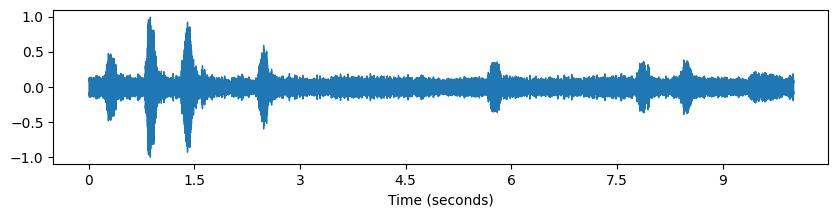

In [7]:
sr = 32000 
example_wav, _ = liro.load(example_file, sr=sr)
wav_plot(example_wav, sr)

## Apply Pre-emphasis (Digital Filter)

* Lower frequencies tend to carry more energy than higher frequencies (drops around 2 dB/kHz)
* Pre-emphasis **compensates for the average spectral shape** and **emphasizes higher frequencies**
* implemented as **time-domain FIR**

In [8]:
preemphasis_coefficient = torch.as_tensor([[[-.97, 1]]])
wav_torch = torch.from_numpy(example_wav)
wav_pree = nn.functional.conv1d(wav_torch.reshape(1, 1, -1), preemphasis_coefficient).squeeze(1)

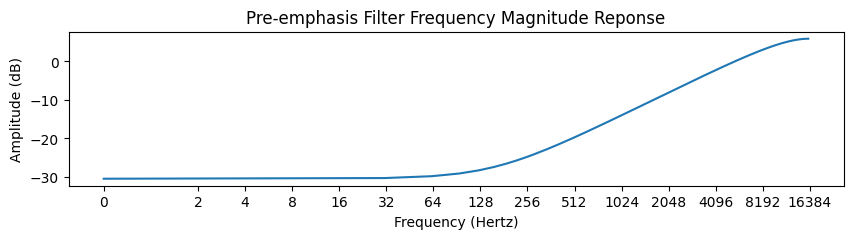

In [9]:
freq_plot(preemphasis_coefficient.squeeze().numpy(), sr, title="Pre-emphasis Filter Frequency Magnitude Reponse")

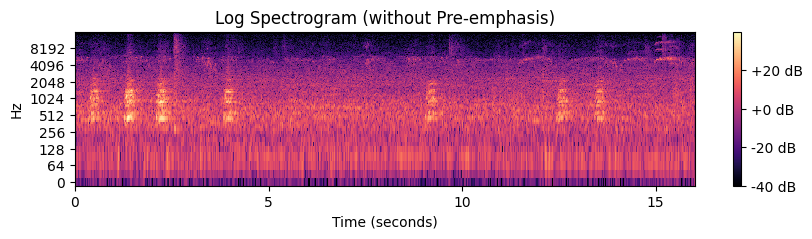

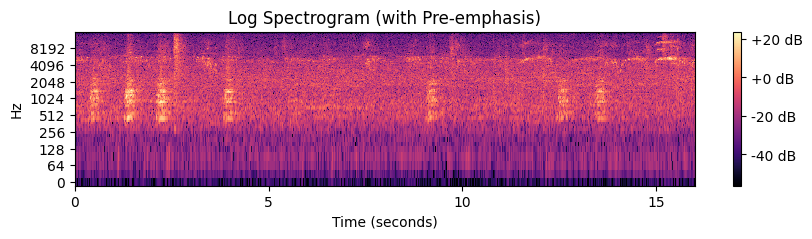

In [10]:
spec_liro(example_wav, sr, title="Log Spectrogram (without Pre-emphasis)")
spec_liro(wav_pree.squeeze().numpy(), sr, title="Log Spectrogram (with Pre-emphasis)")

## STFT


In [11]:
n_fft, win_length, hop_length = 1024, 800, 320 
window = torch.hann_window(win_length, periodic=False)
spec = torch.stft(wav_pree, n_fft=n_fft, hop_length=hop_length,
                  win_length=win_length, center=True,
                  normalized=False, window=window, 
                  return_complex=True)
print("Complex spec shape: ", spec.shape)
spec = torch.view_as_real(spec)
print("Real spec shape: ", spec.shape)
power_spec = (spec ** 2).sum(dim=-1)
# for comparison, we calculate also the magnitude spectrogram
mag_spec = torch.sqrt(power_spec)

Complex spec shape:  torch.Size([1, 513, 1000])
Real spec shape:  torch.Size([1, 513, 1000, 2])


## STFT Window

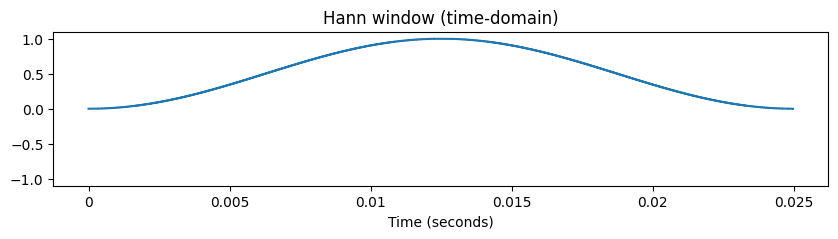

In [12]:
wav_plot(window.squeeze().numpy(), sr, listen=False, title="Hann window (time-domain)")

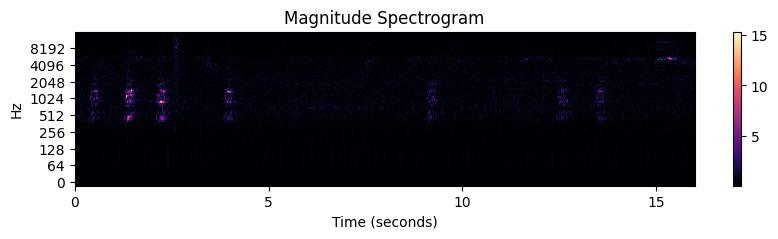

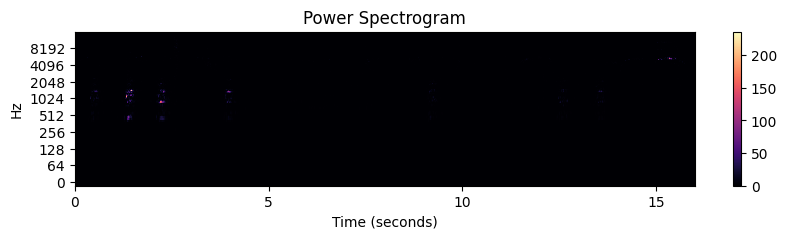

In [13]:
spec_liro(mag_spec.squeeze().numpy(), sr, x_is_spec=True, convert_to_db=False, title="Magnitude Spectrogram")
spec_liro(power_spec.squeeze().numpy(), sr, x_is_power_spec=True, convert_to_db=False, title="Power Spectrogram")

## Mel Transformation

In [14]:
n_mels, fmin, fmax = 40, 0.0, sr // 2
mel_basis, _ = torchaudio.compliance.kaldi.get_mel_banks(n_mels, n_fft, sr,
                                                         fmin, fmax, 
                                                         vtln_low=100.0,
                                                         vtln_high=-500.,
                                                         vtln_warp_factor=1.0)
# pad with one zero per mel bin to match n_fft // 2 + 1
mel_basis = torch.as_tensor(torch.nn.functional.pad(
    mel_basis, (0, 1), mode='constant', value=0)
)

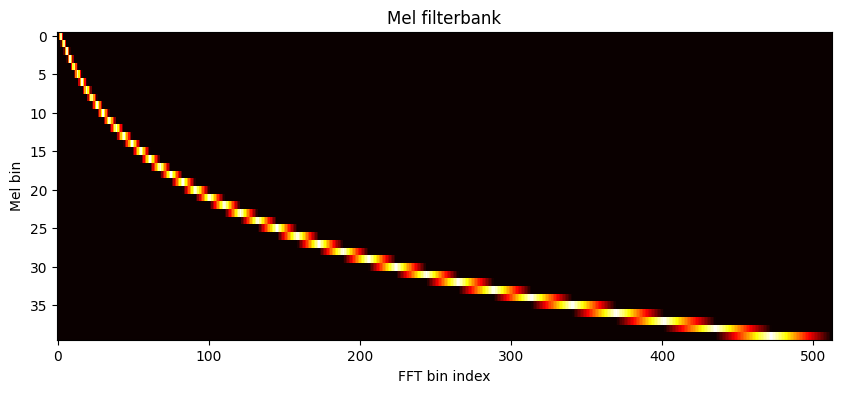

In [15]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 4))
ax.set_title("Mel filterbank")
ax.set_xlabel("FFT bin index")
ax.set_ylabel("Mel bin")
ax.imshow(mel_basis.squeeze().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

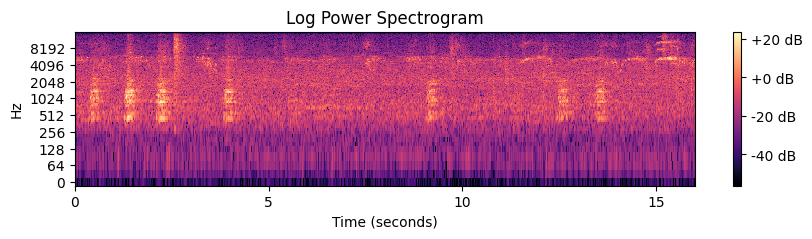

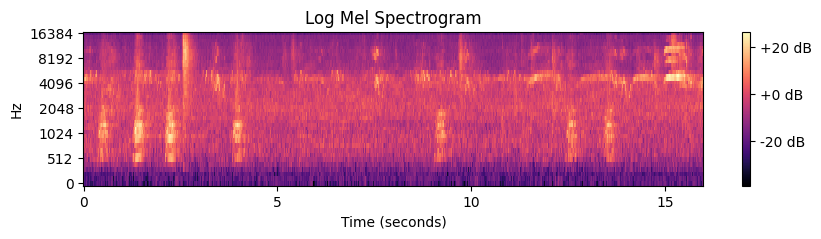

In [16]:
melspec = torch.matmul(mel_basis, power_spec)
spec_liro(power_spec.squeeze().numpy(), sr, x_is_power_spec=True, title="Log Power Spectrogram")
spec_liro(melspec.squeeze().numpy(), sr, x_is_mel_spec=True, title="Log Mel Spectrogram")

##  Why the 'Log' in amplitude?

**Perceived loudness** and **sound power** have a **logarithmic relationship**. Increasing the sound power by a factor of 10 increases the perceived loudness by about a factor of 2. We account for that by taking the logarithm of sound power in our preprocessing pipeline.

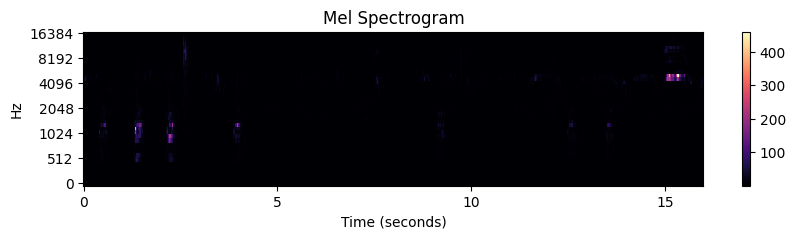

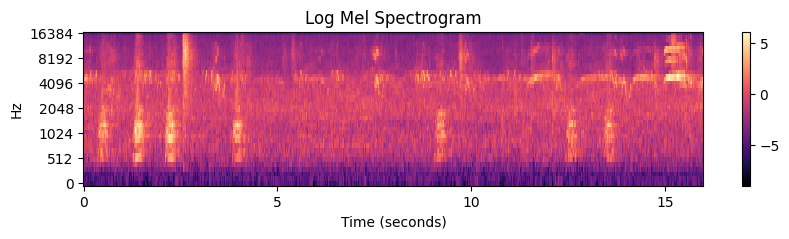

In [17]:
log_mel_spec = (melspec + 0.00001).log()
spec_liro(melspec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Mel Spectrogram")
spec_liro(log_mel_spec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Log Mel Spectrogram")

## Normalization

We often want to **normalize spectrograms by dataset mean and variance**. Below we use approximated mean (-4.5) and standard deviation (5). However, **running through the dataset** and calculating mean and standard deviation is the usual way to go.

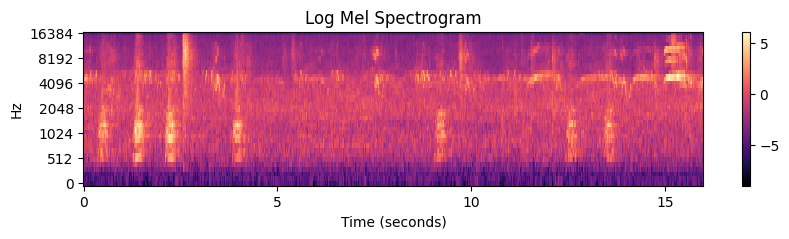

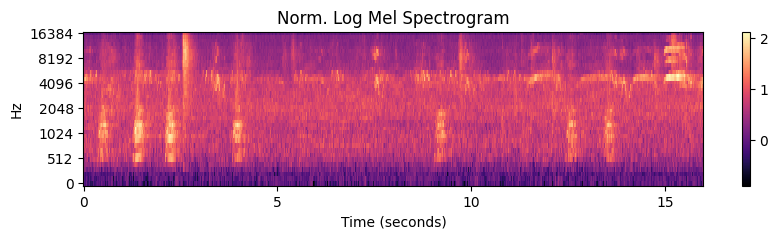

In [18]:
norm_log_mel_spec = (log_mel_spec + 4.5) / 5.
spec_liro(log_mel_spec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Log Mel Spectrogram")
spec_liro(norm_log_mel_spec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Norm. Log Mel Spectrogram")

### What to do with a normalized log mel spectrogram?

**Use your favorite vision architecture and treat the normalized log mel spectrogram as an image with a single input channel.**

## Example Pipeline on GitHub

The <a href=https://github.com/fschmid56/malach24> example ML4Audio pipeline </a> demonstrates the following points based on 200 wav files:

* Dataset loading, PyTorch Dataset class, PyTorch Dataloader
* our pre-processing routine that we discussed today
* how to use a PyTorch Model (CNN) to generate predictions based on a log mel spectrogram
* simple data augmentation techniques (masking time frames, masking frequency bands, mixup, time rolling)
* a training loop implemented with <a href=https://lightning.ai/>Pytorch Lightning</a>
* logging implemented with <a href=https://wandb.ai/site>Weights and Biases</a>
* **some** of the best practices we discussed today

# Your next goal

* Settle for a particular approach (DCASE baseline system for your task, or system described in a technical report)
* Pick an approach that you can handle w.r.t. to its (computational) complexity
* Implement this approach in your own pipeline
* Run a successful experiment and **show us the logged metrics**
* Read the detailed task description as soon as it is out (1st of April)

**Finish until 10.04.24** (after easter holidays)

# Until 20.03.24 (our next meeting)

Prepare a presentation (up to 20 minutes) including:

* detailed information about the system you are going to implement
* the current state of your pipeline (how are you going to structure it?)
* decision on which frameworks (e.g., pytorch, pytorch lightning, weights and biases) you are planning to use 
* possible technical difficulties in implementing the chosen approach that you would like to discuss with us

You may use the <a href=https://github.com/fschmid56/malach24> example ML4Audio pipeline </a> to get started.

# Questions 

* Do you feel comfortable with today's content?
* Do you have computing resources available? Do you need resources from us?
* More questions?

# Your Presentations